In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import requests
import os
import csv
import keras
import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy 

Using TensorFlow backend.


Pulls data from websites and stores them in csv files

In [2]:
def update_data():
    positive_cases_csv_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    req = requests.get(positive_cases_csv_URL)
    URL_content = req.content
    positive_cases_file = open("positive_cases.csv", "wb")
    positive_cases_file.write(URL_content)
    positive_cases_file.close()

This is purely for the sources of data that include data outside the UK as having international data would mean too much to parse through

In [3]:
def filter_data(filename):
    uk = list()
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile)
        for row in reader:
            if row[0] == "GBR" or row[0] == "iso_code":
                uk.append(row)
    
    with open(filename, 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows(uk)  


Counts the number of days since the earliest data entry

In [4]:
def numberofdays(date_in_question):
    start_date = date(2020, 1, 31)
    dateq = date_in_question.split("-")
    cdate = date(int(dateq[0]), int(dateq[1]), int(dateq[2]))
    return (cdate - start_date).days

This will normalise all the data in a dataframe

In [5]:
def normalise_dataframe(df):
    for i in range(1, len(df.columns)):
        maxi = max(df.iloc[:,i])
        mini = min(df.iloc[:,i])
        for j in range(len(df.iloc[:,0])):
            df.iloc[j, i] = (df.iloc[j, i] - mini)/(maxi-mini)

This will only take columns in the data frame with no NaNs

In [6]:
def no_NaNs(df):
    data = []
    for column in df.columns:
        temp = [float(i) for i in df[column]]
        if np.isnan(np.sum(np.array(temp))):
            df.drop([column], inplace=True, axis=1)

This will only take columns that don't have a single repeating entry

In [7]:
def no_repeat(df):
    data = []
    for column in df.columns:
        if df[column].nunique() == 1:
            df.drop([column], inplace=True, axis=1)

This will create the input array for the Neural Network

In [8]:
def create_features(df, window_size, forecast):
    features = []
    labels = []
    i = window_size;
    while i < len(df.iloc[:, 0]) - forecast-1:
        window = df.iloc[i - window_size: i, 1:]
        window = np.array(window)
        window = window.flatten()
        labels.append(df.iloc[i + forecast, 0])
        features.append(window)
        i += 1
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

In [9]:
update_data() 

In [10]:
filter_data("positive_cases.csv")

Grabs the current working directory where the csv files are stored

In [11]:
working_dir = os.getcwd()

Reads the csv files into their respective dataframes

In [12]:
pos_cases_df = pd.read_csv(os.path.join(working_dir, "positive_cases.csv"))
pos_cases_df.drop(pos_cases_df.iloc[:, 0:3], inplace = True, axis=1)
dates = pos_cases_df["date"]
pos_cases_df.drop(["date"], inplace = True, axis=1)
pos_cases_df.drop(["tests_units"], inplace = True, axis=1)

In [13]:
no_NaNs(pos_cases_df)

In [14]:
no_repeat(pos_cases_df)

In [75]:
print((pos_cases_df.head()).to_markdown())

|    |   total_cases |   new_cases |   total_cases_per_million |   new_cases_per_million |   stringency_index |
|---:|--------------:|------------:|--------------------------:|------------------------:|-------------------:|
|  0 |             2 |           2 |                     0.029 |                   0.029 |               8.33 |
|  1 |             2 |           0 |                     0.029 |                   0     |               8.33 |
|  2 |             2 |           0 |                     0.029 |                   0     |              11.11 |
|  3 |             8 |           6 |                     0.118 |                   0.088 |              11.11 |
|  4 |             8 |           0 |                     0.118 |                   0     |              11.11 |


Code just adds a column to the dataframe that counts the number of days since the earliest data entry

In [15]:
daysSince = []
for i in range(len(pos_cases_df)):
    daysSince.append(i)
pos_cases_df["daysSince"] = daysSince

In [78]:
print((pos_cases_df.head()).to_markdown())

|    |   total_cases |   new_cases |   total_cases_per_million |   new_cases_per_million |   stringency_index |   daysSince |
|---:|--------------:|------------:|--------------------------:|------------------------:|-------------------:|------------:|
|  0 |             2 |           2 |                     0.029 |                   0.029 |               8.33 |           0 |
|  1 |             2 |           0 |                     0.029 |                   0     |               8.33 |           1 |
|  2 |             2 |           0 |                     0.029 |                   0     |              11.11 |           2 |
|  3 |             8 |           6 |                     0.118 |                   0.088 |              11.11 |           3 |
|  4 |             8 |           0 |                     0.118 |                   0     |              11.11 |           4 |


Here I make the feature and label matrices with a 7 day window and a 1 day forecast

In [16]:
window_size = 7
forecast = 1
features1, labels1 = create_features(pos_cases_df, window_size, forecast)

Splitting the feature and label matrices into training and testing by 8:2. I will split the training further down into 8:2 again for validation.

In [17]:
training_features1, testing_features1 = np.split(features1, [int(0.8*len(features1))])
training_labels1, testing_labels1 = np.split(labels1, [int(0.8*len(labels1))])

In [18]:
input_shape = training_features1.shape[1]

In [19]:
NN_model = Sequential()
# Input layer
NN_model.add(Dense(128, input_dim=input_shape, kernel_initializer="normal", activation="relu"))
# Hidden Layers
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
NN_model.add(Dense(256, kernel_initializer="normal", activation="relu"))
# Output layer 
NN_model.add(Dense(1, kernel_initializer="normal", activation="linear"))

NN_model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["accuracy"])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3712      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________


In [20]:
history1 = NN_model.fit(training_features1, training_labels1, epochs=500, validation_split=0.2)

Train on 261 samples, validate on 66 samples
Epoch 1/500
261/261 [==============================] - 0s 888us/step - loss: 250428.5345 - accuracy: 0.0000e+00 - val_loss: 1553346.3485 - val_accuracy: 0.0000e+00
Epoch 2/500
261/261 [==============================] - 0s 120us/step - loss: 229867.9078 - accuracy: 0.0000e+00 - val_loss: 1138850.6780 - val_accuracy: 0.0000e+00
Epoch 3/500
261/261 [==============================] - 0s 60us/step - loss: 119646.5588 - accuracy: 0.0000e+00 - val_loss: 887179.9811 - val_accuracy: 0.0000e+00
Epoch 4/500
261/261 [==============================] - 0s 120us/step - loss: 96479.3670 - accuracy: 0.0000e+00 - val_loss: 177836.5076 - val_accuracy: 0.0000e+00
Epoch 5/500
261/261 [==============================] - 0s 120us/step - loss: 58001.1678 - accuracy: 0.0000e+00 - val_loss: 120781.4773 - val_accuracy: 0.0000e+00
Epoch 6/500
261/261 [==============================] - 0s 85us/step - loss: 31806.1906 - accuracy: 0.0000e+00 - val_loss: 42505.5975 - val_ac

261/261 [==============================] - 0s 120us/step - loss: 7813.2213 - accuracy: 0.0077 - val_loss: 22604.2652 - val_accuracy: 0.0000e+00
Epoch 53/500
261/261 [==============================] - 0s 120us/step - loss: 3996.2738 - accuracy: 0.0038 - val_loss: 26641.2803 - val_accuracy: 0.0000e+00
Epoch 54/500
261/261 [==============================] - 0s 85us/step - loss: 6110.6123 - accuracy: 0.0115 - val_loss: 18711.2756 - val_accuracy: 0.0000e+00
Epoch 55/500
261/261 [==============================] - 0s 120us/step - loss: 8015.5329 - accuracy: 0.0000e+00 - val_loss: 35394.9669 - val_accuracy: 0.0000e+00
Epoch 56/500
261/261 [==============================] - 0s 60us/step - loss: 4705.8509 - accuracy: 0.0115 - val_loss: 33219.2178 - val_accuracy: 0.0000e+00
Epoch 57/500
261/261 [==============================] - 0s 145us/step - loss: 6078.4127 - accuracy: 0.0077 - val_loss: 40121.3902 - val_accuracy: 0.0000e+00
Epoch 58/500
261/261 [==============================] - 0s 60us/step 

261/261 [==============================] - 0s 120us/step - loss: 2098.8510 - accuracy: 0.0077 - val_loss: 12704.2907 - val_accuracy: 0.0000e+00
Epoch 105/500
261/261 [==============================] - 0s 60us/step - loss: 2501.9112 - accuracy: 0.0115 - val_loss: 16845.4299 - val_accuracy: 0.0000e+00
Epoch 106/500
261/261 [==============================] - 0s 145us/step - loss: 1485.6267 - accuracy: 0.0115 - val_loss: 13127.3523 - val_accuracy: 0.0000e+00
Epoch 107/500
261/261 [==============================] - 0s 60us/step - loss: 1392.3556 - accuracy: 0.0192 - val_loss: 9047.4669 - val_accuracy: 0.0000e+00
Epoch 108/500
261/261 [==============================] - 0s 120us/step - loss: 2665.5764 - accuracy: 0.0192 - val_loss: 8344.8977 - val_accuracy: 0.0000e+00
Epoch 109/500
261/261 [==============================] - 0s 60us/step - loss: 2297.0923 - accuracy: 0.0038 - val_loss: 7758.2377 - val_accuracy: 0.0000e+00
Epoch 110/500
261/261 [==============================] - 0s 85us/step - 

261/261 [==============================] - 0s 85us/step - loss: 6205.9133 - accuracy: 0.0192 - val_loss: 33810.7481 - val_accuracy: 0.0000e+00
Epoch 157/500
261/261 [==============================] - 0s 120us/step - loss: 5214.2052 - accuracy: 0.0115 - val_loss: 42720.8182 - val_accuracy: 0.0000e+00
Epoch 158/500
261/261 [==============================] - 0s 120us/step - loss: 3114.6331 - accuracy: 0.0038 - val_loss: 21365.3996 - val_accuracy: 0.0000e+00
Epoch 159/500
261/261 [==============================] - 0s 85us/step - loss: 2464.7165 - accuracy: 0.0192 - val_loss: 35942.8826 - val_accuracy: 0.0000e+00
Epoch 160/500
261/261 [==============================] - 0s 60us/step - loss: 2581.8911 - accuracy: 0.0153 - val_loss: 13032.7178 - val_accuracy: 0.0000e+00
Epoch 161/500
261/261 [==============================] - 0s 60us/step - loss: 1723.1325 - accuracy: 0.0077 - val_loss: 6538.0966 - val_accuracy: 0.0000e+00
Epoch 162/500
261/261 [==============================] - 0s 120us/step 

261/261 [==============================] - 0s 89us/step - loss: 5586.8667 - accuracy: 0.0153 - val_loss: 34371.5795 - val_accuracy: 0.0000e+00
Epoch 209/500
261/261 [==============================] - 0s 60us/step - loss: 4866.4736 - accuracy: 0.0077 - val_loss: 23815.6080 - val_accuracy: 0.0000e+00
Epoch 210/500
261/261 [==============================] - 0s 120us/step - loss: 2750.5042 - accuracy: 0.0115 - val_loss: 52573.1780 - val_accuracy: 0.0000e+00
Epoch 211/500
261/261 [==============================] - 0s 120us/step - loss: 6807.1546 - accuracy: 0.0115 - val_loss: 74135.3996 - val_accuracy: 0.0000e+00
Epoch 212/500
261/261 [==============================] - 0s 59us/step - loss: 7064.3384 - accuracy: 0.0153 - val_loss: 67880.8939 - val_accuracy: 0.0000e+00
Epoch 213/500
261/261 [==============================] - 0s 60us/step - loss: 5404.9390 - accuracy: 0.0153 - val_loss: 9399.8826 - val_accuracy: 0.0000e+00
Epoch 214/500
261/261 [==============================] - 0s 120us/step 

261/261 [==============================] - 0s 96us/step - loss: 4042.3549 - accuracy: 0.0230 - val_loss: 13554.2036 - val_accuracy: 0.0000e+00
Epoch 261/500
261/261 [==============================] - 0s 96us/step - loss: 2272.7866 - accuracy: 0.0307 - val_loss: 28986.1581 - val_accuracy: 0.0000e+00
Epoch 262/500
261/261 [==============================] - 0s 100us/step - loss: 2192.4445 - accuracy: 0.0345 - val_loss: 12710.9792 - val_accuracy: 0.0000e+00
Epoch 263/500
261/261 [==============================] - 0s 96us/step - loss: 2507.2079 - accuracy: 0.0268 - val_loss: 7218.1960 - val_accuracy: 0.0000e+00
Epoch 264/500
261/261 [==============================] - 0s 92us/step - loss: 1659.8917 - accuracy: 0.0230 - val_loss: 8961.8703 - val_accuracy: 0.0000e+00
Epoch 265/500
261/261 [==============================] - 0s 96us/step - loss: 2053.0285 - accuracy: 0.0115 - val_loss: 35604.5597 - val_accuracy: 0.0000e+00
Epoch 266/500
261/261 [==============================] - 0s 103us/step - 

261/261 [==============================] - 0s 145us/step - loss: 1897.5013 - accuracy: 0.0230 - val_loss: 7782.3475 - val_accuracy: 0.0000e+00
Epoch 313/500
261/261 [==============================] - 0s 60us/step - loss: 2441.0759 - accuracy: 0.0268 - val_loss: 10667.8835 - val_accuracy: 0.0000e+00
Epoch 314/500
261/261 [==============================] - 0s 120us/step - loss: 2452.5288 - accuracy: 0.0153 - val_loss: 15166.6525 - val_accuracy: 0.0000e+00
Epoch 315/500
261/261 [==============================] - 0s 120us/step - loss: 4875.7519 - accuracy: 0.0077 - val_loss: 63249.9886 - val_accuracy: 0.0000e+00
Epoch 316/500
261/261 [==============================] - 0s 85us/step - loss: 6611.6276 - accuracy: 0.0307 - val_loss: 17705.0663 - val_accuracy: 0.0000e+00
Epoch 317/500
261/261 [==============================] - 0s 60us/step - loss: 1596.8021 - accuracy: 0.0038 - val_loss: 21280.7235 - val_accuracy: 0.0000e+00
Epoch 318/500
261/261 [==============================] - 0s 60us/step 

261/261 [==============================] - 0s 60us/step - loss: 4093.7128 - accuracy: 0.0268 - val_loss: 26818.4858 - val_accuracy: 0.0000e+00
Epoch 365/500
261/261 [==============================] - 0s 145us/step - loss: 2690.5056 - accuracy: 0.0192 - val_loss: 17902.3494 - val_accuracy: 0.0000e+00
Epoch 366/500
261/261 [==============================] - 0s 60us/step - loss: 2599.7880 - accuracy: 0.0153 - val_loss: 36759.6487 - val_accuracy: 0.0000e+00
Epoch 367/500
261/261 [==============================] - 0s 120us/step - loss: 3635.3106 - accuracy: 0.0192 - val_loss: 9046.1174 - val_accuracy: 0.0000e+00
Epoch 368/500
261/261 [==============================] - 0s 120us/step - loss: 3090.7737 - accuracy: 0.0153 - val_loss: 6961.7680 - val_accuracy: 0.0000e+00
Epoch 369/500
261/261 [==============================] - 0s 85us/step - loss: 2418.3758 - accuracy: 0.0230 - val_loss: 11831.5559 - val_accuracy: 0.0000e+00
Epoch 370/500
261/261 [==============================] - 0s 60us/step -

261/261 [==============================] - 0s 96us/step - loss: 12535.2261 - accuracy: 0.0038 - val_loss: 89824.8068 - val_accuracy: 0.0000e+00
Epoch 417/500
261/261 [==============================] - 0s 92us/step - loss: 6482.2158 - accuracy: 0.0115 - val_loss: 30282.5019 - val_accuracy: 0.0000e+00
Epoch 418/500
261/261 [==============================] - 0s 96us/step - loss: 6233.6863 - accuracy: 0.0153 - val_loss: 47861.7292 - val_accuracy: 0.0000e+00
Epoch 419/500
261/261 [==============================] - 0s 96us/step - loss: 3418.0284 - accuracy: 0.0268 - val_loss: 8482.3968 - val_accuracy: 0.0000e+00
Epoch 420/500
261/261 [==============================] - 0s 92us/step - loss: 2387.0843 - accuracy: 0.0077 - val_loss: 6663.8911 - val_accuracy: 0.0000e+00
Epoch 421/500
261/261 [==============================] - 0s 92us/step - loss: 4483.3617 - accuracy: 0.0230 - val_loss: 39259.3220 - val_accuracy: 0.0000e+00
Epoch 422/500
261/261 [==============================] - 0s 100us/step - 

261/261 [==============================] - 0s 85us/step - loss: 3868.5937 - accuracy: 0.0268 - val_loss: 12693.7121 - val_accuracy: 0.0000e+00
Epoch 469/500
261/261 [==============================] - 0s 120us/step - loss: 2246.9058 - accuracy: 0.0115 - val_loss: 6950.0616 - val_accuracy: 0.0000e+00
Epoch 470/500
261/261 [==============================] - 0s 60us/step - loss: 1750.8737 - accuracy: 0.0230 - val_loss: 18155.2235 - val_accuracy: 0.0000e+00
Epoch 471/500
261/261 [==============================] - 0s 60us/step - loss: 1858.4267 - accuracy: 0.0307 - val_loss: 28544.6373 - val_accuracy: 0.0000e+00
Epoch 472/500
261/261 [==============================] - 0s 85us/step - loss: 3705.1320 - accuracy: 0.0268 - val_loss: 31003.5634 - val_accuracy: 0.0000e+00
Epoch 473/500
261/261 [==============================] - 0s 153us/step - loss: 3824.1467 - accuracy: 0.0307 - val_loss: 7922.5881 - val_accuracy: 0.0000e+00
Epoch 474/500
261/261 [==============================] - 0s 96us/step - 

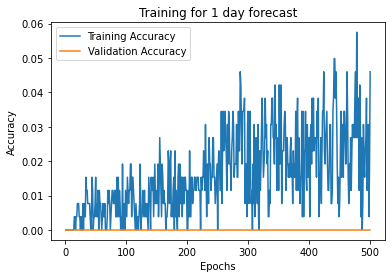

In [22]:
epochs = range(1, len(history1.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history1.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training for 1 day forecast")
plt.legend()
plt.show()

In [23]:
x = [i for i in range(int(testing_features1[0,-1]+1), int(testing_features1[-1,-1]+2))]
y = testing_labels1
x_pred = testing_features1
y_pred = NN_model.predict(x_pred)
err1 = np.abs(y - y_pred)
acc1 = np.ones(len(y)) - np.divide(err1, y)
acc_bar1 = np.mean(acc1)
rms1 = np.sqrt(np.mean((err1)**2))
print("Average accuracy:", acc_bar1)
print("RMS:", rms1)

Average accuracy: 0.8485905486581791
RMS: 705828.519894445


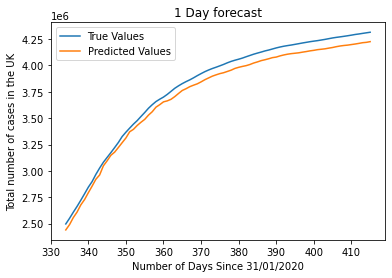

In [25]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Number of Days Since 31/01/2020")
plt.ylabel("Total number of cases in the UK")
plt.title("1 Day forecast")
plt.legend()
plt.show()

Here I make a new feature and label matrix with a 7 day window and a 2 day forecast

In [24]:
window_size = 7
forecast = 2
features2, labels2 = create_features(pos_cases_df, window_size, forecast)

I split the matrices down into training and testing using a 8:2 splitting

In [25]:
training_features2, testing_features2 = np.split(features2, [int(0.8*len(features2))])
training_labels2, testing_labels2 = np.split(labels2, [int(0.8*len(labels2))])

The model has to be trained again with this new data

In [26]:
history2 = NN_model.fit(training_features2, training_labels2, epochs=500, validation_split=0.2)

Train on 260 samples, validate on 65 samples
Epoch 1/500
260/260 [==============================] - 0s 108us/step - loss: 2383.7948 - accuracy: 0.0500 - val_loss: 14385.0096 - val_accuracy: 0.0000e+00
Epoch 2/500
260/260 [==============================] - 0s 100us/step - loss: 3403.7125 - accuracy: 0.0192 - val_loss: 12958.1769 - val_accuracy: 0.0000e+00
Epoch 3/500
260/260 [==============================] - 0s 96us/step - loss: 3446.8550 - accuracy: 0.0038 - val_loss: 14320.5529 - val_accuracy: 0.0000e+00
Epoch 4/500
260/260 [==============================] - 0s 100us/step - loss: 3657.5492 - accuracy: 0.0231 - val_loss: 13762.2942 - val_accuracy: 0.0000e+00
Epoch 5/500
260/260 [==============================] - 0s 96us/step - loss: 3023.6319 - accuracy: 0.0154 - val_loss: 30323.4173 - val_accuracy: 0.0000e+00
Epoch 6/500
260/260 [==============================] - 0s 108us/step - loss: 4784.1897 - accuracy: 0.0154 - val_loss: 38494.2538 - val_accuracy: 0.0000e+00
Epoch 7/500
260/260 [

260/260 [==============================] - 0s 96us/step - loss: 2211.5981 - accuracy: 0.0192 - val_loss: 12922.5067 - val_accuracy: 0.0000e+00
Epoch 54/500
260/260 [==============================] - 0s 92us/step - loss: 2644.2682 - accuracy: 0.0077 - val_loss: 31259.1250 - val_accuracy: 0.0000e+00
Epoch 55/500
260/260 [==============================] - 0s 96us/step - loss: 2859.8394 - accuracy: 0.0154 - val_loss: 13921.4221 - val_accuracy: 0.0000e+00
Epoch 56/500
260/260 [==============================] - 0s 92us/step - loss: 2894.6120 - accuracy: 0.0269 - val_loss: 45710.3096 - val_accuracy: 0.0000e+00
Epoch 57/500
260/260 [==============================] - 0s 100us/step - loss: 5029.8058 - accuracy: 0.0077 - val_loss: 11594.5394 - val_accuracy: 0.0000e+00
Epoch 58/500
260/260 [==============================] - 0s 96us/step - loss: 3597.6629 - accuracy: 0.0154 - val_loss: 16641.6981 - val_accuracy: 0.0000e+00
Epoch 59/500
260/260 [==============================] - 0s 92us/step - loss:

260/260 [==============================] - 0s 96us/step - loss: 3552.9194 - accuracy: 0.0423 - val_loss: 10065.1038 - val_accuracy: 0.0000e+00
Epoch 158/500
260/260 [==============================] - 0s 96us/step - loss: 4489.4032 - accuracy: 0.0269 - val_loss: 52145.9019 - val_accuracy: 0.0000e+00
Epoch 159/500
260/260 [==============================] - 0s 85us/step - loss: 5078.0374 - accuracy: 0.0269 - val_loss: 15845.6981 - val_accuracy: 0.0000e+00
Epoch 160/500
260/260 [==============================] - 0s 104us/step - loss: 2207.3103 - accuracy: 0.0308 - val_loss: 11082.0865 - val_accuracy: 0.0000e+00
Epoch 161/500
260/260 [==============================] - 0s 96us/step - loss: 2345.4001 - accuracy: 0.0385 - val_loss: 34012.1394 - val_accuracy: 0.0000e+00
Epoch 162/500
260/260 [==============================] - 0s 92us/step - loss: 3740.5037 - accuracy: 0.0192 - val_loss: 39287.3115 - val_accuracy: 0.0000e+00
Epoch 163/500
260/260 [==============================] - 0s 88us/step -

260/260 [==============================] - 0s 92us/step - loss: 3585.8859 - accuracy: 0.0308 - val_loss: 29104.7923 - val_accuracy: 0.0000e+00
Epoch 262/500
260/260 [==============================] - 0s 100us/step - loss: 2544.1179 - accuracy: 0.0308 - val_loss: 17424.0019 - val_accuracy: 0.0000e+00
Epoch 263/500
260/260 [==============================] - 0s 97us/step - loss: 1895.4123 - accuracy: 0.0077 - val_loss: 14496.8010 - val_accuracy: 0.0000e+00
Epoch 264/500
260/260 [==============================] - 0s 92us/step - loss: 2694.7988 - accuracy: 0.0077 - val_loss: 12241.3846 - val_accuracy: 0.0000e+00
Epoch 265/500
260/260 [==============================] - 0s 96us/step - loss: 2743.2368 - accuracy: 0.0269 - val_loss: 21110.9250 - val_accuracy: 0.0000e+00
Epoch 266/500
260/260 [==============================] - 0s 92us/step - loss: 3060.7201 - accuracy: 0.0192 - val_loss: 20913.2865 - val_accuracy: 0.0000e+00
Epoch 267/500
260/260 [==============================] - 0s 96us/step -

260/260 [==============================] - 0s 100us/step - loss: 10395.4351 - accuracy: 0.0077 - val_loss: 20222.5885 - val_accuracy: 0.0000e+00
Epoch 366/500
260/260 [==============================] - 0s 96us/step - loss: 7866.1855 - accuracy: 0.0115 - val_loss: 16366.4173 - val_accuracy: 0.0000e+00
Epoch 367/500
260/260 [==============================] - 0s 88us/step - loss: 5415.0463 - accuracy: 0.0038 - val_loss: 13576.9962 - val_accuracy: 0.0000e+00
Epoch 368/500
260/260 [==============================] - 0s 92us/step - loss: 4519.8575 - accuracy: 0.0115 - val_loss: 18605.1875 - val_accuracy: 0.0000e+00
Epoch 369/500
260/260 [==============================] - 0s 95us/step - loss: 2658.1640 - accuracy: 0.0077 - val_loss: 10513.2615 - val_accuracy: 0.0000e+00
Epoch 370/500
260/260 [==============================] - 0s 104us/step - loss: 2302.6142 - accuracy: 0.0038 - val_loss: 9679.2683 - val_accuracy: 0.0000e+00
Epoch 371/500
260/260 [==============================] - 0s 100us/step

260/260 [==============================] - 0s 92us/step - loss: 1521.7992 - accuracy: 0.0231 - val_loss: 13721.7163 - val_accuracy: 0.0000e+00
Epoch 470/500
260/260 [==============================] - 0s 92us/step - loss: 1572.9030 - accuracy: 0.0346 - val_loss: 9064.0462 - val_accuracy: 0.0000e+00
Epoch 471/500
260/260 [==============================] - 0s 96us/step - loss: 1289.5295 - accuracy: 0.0269 - val_loss: 15669.3519 - val_accuracy: 0.0000e+00
Epoch 472/500
260/260 [==============================] - 0s 92us/step - loss: 2234.6545 - accuracy: 0.0385 - val_loss: 11908.3135 - val_accuracy: 0.0000e+00
Epoch 473/500
260/260 [==============================] - 0s 88us/step - loss: 1975.1783 - accuracy: 0.0423 - val_loss: 9784.5750 - val_accuracy: 0.0000e+00
Epoch 474/500
260/260 [==============================] - 0s 96us/step - loss: 1531.6806 - accuracy: 0.0423 - val_loss: 12468.3077 - val_accuracy: 0.0000e+00
Epoch 475/500
260/260 [==============================] - 0s 96us/step - lo

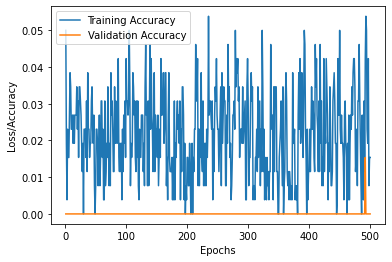

In [27]:
epochs = range(1, len(history2.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history2.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [28]:
x = [i for i in range(int(testing_features2[0,-1]+1), int(testing_features2[-1,-1]+2))]
y = testing_labels2
x_pred = testing_features2
y_pred = NN_model.predict(x_pred) 
err2 = np.abs(y - y_pred)
acc2 = np.ones(len(y)) - np.divide(err2, y)
acc_bar2 = np.mean(acc2)
rms2 = np.sqrt(np.mean((err2)**2))
print("Average accuracy:", acc_bar2)
print("RMS:", rms2)

Average accuracy: 0.8399270877248225
RMS: 736515.2953041082


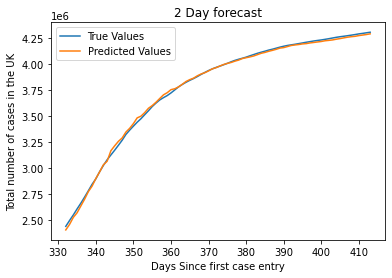

In [29]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("2 Day forecast")
plt.legend()
plt.show()

In [30]:
window_size = 7
forecast = 3
features3, labels3 = create_features(pos_cases_df, window_size, forecast)

In [31]:
training_features3, testing_features3 = np.split(features3, [int(0.8*len(features3))])
training_labels3, testing_labels3 = np.split(labels3, [int(0.8*len(labels3))])

In [32]:
history3 = NN_model.fit(training_features3, training_labels3, epochs=500, validation_split=0.2)

Train on 259 samples, validate on 65 samples
Epoch 1/500
259/259 [==============================] - 0s 107us/step - loss: 3589.3179 - accuracy: 0.0039 - val_loss: 50977.1231 - val_accuracy: 0.0000e+00
Epoch 2/500
259/259 [==============================] - 0s 96us/step - loss: 3805.9738 - accuracy: 0.0347 - val_loss: 20415.3442 - val_accuracy: 0.0000e+00
Epoch 3/500
259/259 [==============================] - 0s 108us/step - loss: 2347.2170 - accuracy: 0.0193 - val_loss: 15539.5827 - val_accuracy: 0.0000e+00
Epoch 4/500
259/259 [==============================] - 0s 112us/step - loss: 1654.0969 - accuracy: 0.0232 - val_loss: 19853.4038 - val_accuracy: 0.0000e+00
Epoch 5/500
259/259 [==============================] - 0s 112us/step - loss: 3009.3574 - accuracy: 0.0232 - val_loss: 23486.6519 - val_accuracy: 0.0000e+00
Epoch 6/500
259/259 [==============================] - 0s 112us/step - loss: 2383.9431 - accuracy: 0.0463 - val_loss: 33014.4144 - val_accuracy: 0.0000e+00
Epoch 7/500
259/259 

259/259 [==============================] - 0s 96us/step - loss: 6463.4907 - accuracy: 0.0232 - val_loss: 45731.8846 - val_accuracy: 0.0000e+00
Epoch 106/500
259/259 [==============================] - 0s 96us/step - loss: 4345.7843 - accuracy: 0.0232 - val_loss: 19759.9471 - val_accuracy: 0.0000e+00
Epoch 107/500
259/259 [==============================] - 0s 96us/step - loss: 2599.6469 - accuracy: 0.0270 - val_loss: 37848.6558 - val_accuracy: 0.0000e+00
Epoch 108/500
259/259 [==============================] - ETA: 0s - loss: 8861.2344 - accuracy: 0.0000e+0 - 0s 96us/step - loss: 6379.4869 - accuracy: 0.0154 - val_loss: 22194.4144 - val_accuracy: 0.0000e+00
Epoch 109/500
259/259 [==============================] - 0s 100us/step - loss: 3784.3842 - accuracy: 0.0347 - val_loss: 46152.1231 - val_accuracy: 0.0000e+00
Epoch 110/500
259/259 [==============================] - 0s 96us/step - loss: 3723.2543 - accuracy: 0.0039 - val_loss: 15134.7817 - val_accuracy: 0.0000e+00
Epoch 111/500
259/259

Epoch 157/500
259/259 [==============================] - 0s 89us/step - loss: 7150.3027 - accuracy: 0.0193 - val_loss: 77881.1692 - val_accuracy: 0.0000e+00
Epoch 158/500
259/259 [==============================] - 0s 108us/step - loss: 5626.5855 - accuracy: 0.0425 - val_loss: 25468.7337 - val_accuracy: 0.0000e+00
Epoch 159/500
259/259 [==============================] - 0s 96us/step - loss: 3953.9580 - accuracy: 0.0077 - val_loss: 18045.7904 - val_accuracy: 0.0000e+00
Epoch 160/500
259/259 [==============================] - 0s 93us/step - loss: 3839.2721 - accuracy: 0.0386 - val_loss: 17868.7625 - val_accuracy: 0.0000e+00
Epoch 161/500
259/259 [==============================] - 0s 93us/step - loss: 2401.6043 - accuracy: 0.0309 - val_loss: 20212.6019 - val_accuracy: 0.0000e+00
Epoch 162/500
259/259 [==============================] - 0s 93us/step - loss: 2294.4634 - accuracy: 0.0347 - val_loss: 12475.6096 - val_accuracy: 0.0000e+00
Epoch 163/500
259/259 [==============================] - 

259/259 [==============================] - 0s 96us/step - loss: 3002.5914 - accuracy: 0.0116 - val_loss: 31433.2673 - val_accuracy: 0.0000e+00
Epoch 210/500
259/259 [==============================] - 0s 96us/step - loss: 2558.0331 - accuracy: 0.0039 - val_loss: 24985.5904 - val_accuracy: 0.0000e+00
Epoch 211/500
259/259 [==============================] - 0s 93us/step - loss: 1914.6151 - accuracy: 0.0077 - val_loss: 15808.1885 - val_accuracy: 0.0000e+00
Epoch 212/500
259/259 [==============================] - 0s 89us/step - loss: 1662.8805 - accuracy: 0.0193 - val_loss: 26825.3240 - val_accuracy: 0.0000e+00
Epoch 213/500
259/259 [==============================] - 0s 93us/step - loss: 2489.9885 - accuracy: 0.0077 - val_loss: 13412.2740 - val_accuracy: 0.0000e+00
Epoch 214/500
259/259 [==============================] - 0s 89us/step - loss: 3518.8151 - accuracy: 0.0077 - val_loss: 37652.4135 - val_accuracy: 0.0000e+00
Epoch 215/500
259/259 [==============================] - 0s 93us/step - 

Epoch 313/500
259/259 [==============================] - 0s 104us/step - loss: 3019.2857 - accuracy: 0.0425 - val_loss: 32544.7019 - val_accuracy: 0.0000e+00
Epoch 314/500
259/259 [==============================] - 0s 96us/step - loss: 2933.0954 - accuracy: 0.0154 - val_loss: 16613.5760 - val_accuracy: 0.0000e+00
Epoch 315/500
259/259 [==============================] - 0s 100us/step - loss: 2629.5021 - accuracy: 0.0116 - val_loss: 17557.1000 - val_accuracy: 0.0000e+00
Epoch 316/500
259/259 [==============================] - 0s 96us/step - loss: 1821.3062 - accuracy: 0.0232 - val_loss: 12634.3404 - val_accuracy: 0.0154
Epoch 317/500
259/259 [==============================] - 0s 96us/step - loss: 2405.3973 - accuracy: 0.0039 - val_loss: 16289.2298 - val_accuracy: 0.0000e+00
Epoch 318/500
259/259 [==============================] - 0s 96us/step - loss: 1644.7902 - accuracy: 0.0116 - val_loss: 40530.5692 - val_accuracy: 0.0000e+00
Epoch 319/500
259/259 [==============================] - 0s 

259/259 [==============================] - 0s 93us/step - loss: 2103.6810 - accuracy: 0.0270 - val_loss: 22941.8202 - val_accuracy: 0.0000e+00
Epoch 418/500
259/259 [==============================] - 0s 100us/step - loss: 3408.8240 - accuracy: 0.0347 - val_loss: 17513.5260 - val_accuracy: 0.0000e+00
Epoch 419/500
259/259 [==============================] - 0s 97us/step - loss: 4603.3152 - accuracy: 0.0232 - val_loss: 27151.2192 - val_accuracy: 0.0000e+00
Epoch 420/500
259/259 [==============================] - 0s 100us/step - loss: 1556.2177 - accuracy: 0.0309 - val_loss: 49087.5250 - val_accuracy: 0.0000e+00
Epoch 421/500
259/259 [==============================] - 0s 96us/step - loss: 4344.2596 - accuracy: 0.0270 - val_loss: 20201.9260 - val_accuracy: 0.0000e+00
Epoch 422/500
259/259 [==============================] - 0s 96us/step - loss: 2886.0949 - accuracy: 0.0347 - val_loss: 67443.6365 - val_accuracy: 0.0000e+00
Epoch 423/500
259/259 [==============================] - 0s 96us/step 

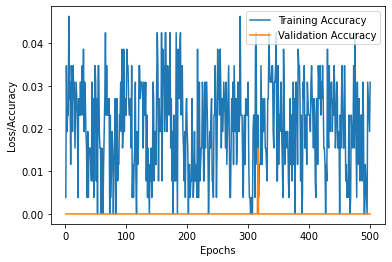

In [33]:
epochs = range(1, len(history3.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history3.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [34]:
x = [i for i in range(int(testing_features3[0,-1]+1), int(testing_features3[-1,-1]+2))]
y = testing_labels3
x_pred = testing_features3
y_pred = NN_model.predict(x_pred) 
err3 = np.abs(y - y_pred)
acc3 = np.ones(len(y)) - np.divide(err3, y)
acc_bar3 = np.mean(acc3)
rms3 = np.sqrt(np.mean((err3)**2))
print("Average accuracy:", acc_bar3)
print("RMS:", rms3)

Average accuracy: 0.8255980318255755
RMS: 778659.5018643439


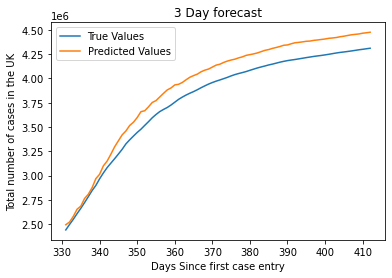

In [35]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("3 Day forecast")
plt.legend()
plt.show()

In [36]:
window_size = 7
forecast = 10
features10, labels10 = create_features(pos_cases_df, window_size, forecast)

In [37]:
training_features10, testing_features10 = np.split(features10, [int(0.8*len(features10))])
training_labels10, testing_labels10 = np.split(labels10, [int(0.8*len(labels10))])

In [38]:
history10 = NN_model.fit(training_features10, training_labels10, epochs=500, validation_split=0.2)

Train on 255 samples, validate on 64 samples
Epoch 1/500
255/255 [==============================] - 0s 106us/step - loss: 18386.1679 - accuracy: 0.0000e+00 - val_loss: 52014.7070 - val_accuracy: 0.0000e+00
Epoch 2/500
255/255 [==============================] - 0s 106us/step - loss: 11976.3748 - accuracy: 0.0000e+00 - val_loss: 47852.4746 - val_accuracy: 0.0000e+00
Epoch 3/500
255/255 [==============================] - 0s 98us/step - loss: 8583.9083 - accuracy: 0.0000e+00 - val_loss: 59721.0371 - val_accuracy: 0.0000e+00
Epoch 4/500
255/255 [==============================] - 0s 98us/step - loss: 8865.1913 - accuracy: 0.0000e+00 - val_loss: 58906.6074 - val_accuracy: 0.0000e+00
Epoch 5/500
255/255 [==============================] - 0s 94us/step - loss: 7713.5812 - accuracy: 0.0000e+00 - val_loss: 51056.6289 - val_accuracy: 0.0000e+00
Epoch 6/500
255/255 [==============================] - 0s 94us/step - loss: 7416.6216 - accuracy: 0.0000e+00 - val_loss: 50256.6719 - val_accuracy: 0.0000e+

255/255 [==============================] - 0s 86us/step - loss: 4942.4391 - accuracy: 0.0078 - val_loss: 70189.7539 - val_accuracy: 0.0000e+00
Epoch 105/500
255/255 [==============================] - 0s 86us/step - loss: 4314.5980 - accuracy: 0.0000e+00 - val_loss: 63527.3008 - val_accuracy: 0.0000e+00
Epoch 106/500
255/255 [==============================] - 0s 82us/step - loss: 4320.8416 - accuracy: 0.0118 - val_loss: 80844.3359 - val_accuracy: 0.0000e+00
Epoch 107/500
255/255 [==============================] - 0s 86us/step - loss: 4613.7394 - accuracy: 0.0118 - val_loss: 65725.8418 - val_accuracy: 0.0000e+00
Epoch 108/500
255/255 [==============================] - 0s 90us/step - loss: 4471.1202 - accuracy: 0.0078 - val_loss: 59485.6895 - val_accuracy: 0.0000e+00
Epoch 109/500
255/255 [==============================] - 0s 90us/step - loss: 4193.8921 - accuracy: 0.0078 - val_loss: 95664.1914 - val_accuracy: 0.0000e+00
Epoch 110/500
255/255 [==============================] - 0s 86us/ste

Epoch 156/500
255/255 [==============================] - 0s 94us/step - loss: 4776.1802 - accuracy: 0.0078 - val_loss: 119233.4766 - val_accuracy: 0.0000e+00
Epoch 157/500
255/255 [==============================] - 0s 90us/step - loss: 4103.5185 - accuracy: 0.0039 - val_loss: 90011.3320 - val_accuracy: 0.0000e+00
Epoch 158/500
255/255 [==============================] - 0s 90us/step - loss: 3795.7017 - accuracy: 0.0196 - val_loss: 77117.8906 - val_accuracy: 0.0000e+00
Epoch 159/500
255/255 [==============================] - 0s 86us/step - loss: 4491.3929 - accuracy: 0.0118 - val_loss: 105700.6641 - val_accuracy: 0.0000e+00
Epoch 160/500
255/255 [==============================] - 0s 86us/step - loss: 3930.2028 - accuracy: 0.0157 - val_loss: 95459.1133 - val_accuracy: 0.0000e+00
Epoch 161/500
255/255 [==============================] - 0s 82us/step - loss: 4089.1007 - accuracy: 0.0078 - val_loss: 83341.4023 - val_accuracy: 0.0000e+00
Epoch 162/500
255/255 [==============================] -

Epoch 208/500
255/255 [==============================] - 0s 90us/step - loss: 3602.3635 - accuracy: 0.0000e+00 - val_loss: 124649.3047 - val_accuracy: 0.0000e+00
Epoch 209/500
255/255 [==============================] - 0s 90us/step - loss: 3726.0182 - accuracy: 0.0118 - val_loss: 84028.9414 - val_accuracy: 0.0000e+00
Epoch 210/500
255/255 [==============================] - 0s 88us/step - loss: 3963.8948 - accuracy: 0.0118 - val_loss: 119444.8828 - val_accuracy: 0.0000e+00
Epoch 211/500
255/255 [==============================] - 0s 90us/step - loss: 3844.0336 - accuracy: 0.0039 - val_loss: 101964.9727 - val_accuracy: 0.0000e+00
Epoch 212/500
255/255 [==============================] - 0s 86us/step - loss: 3482.3313 - accuracy: 0.0118 - val_loss: 104994.2656 - val_accuracy: 0.0000e+00
Epoch 213/500
255/255 [==============================] - 0s 90us/step - loss: 3854.3451 - accuracy: 0.0118 - val_loss: 125494.7930 - val_accuracy: 0.0000e+00
Epoch 214/500
255/255 [==========================

Epoch 260/500
255/255 [==============================] - 0s 86us/step - loss: 5559.9576 - accuracy: 0.0000e+00 - val_loss: 87679.1016 - val_accuracy: 0.0000e+00
Epoch 261/500
255/255 [==============================] - 0s 94us/step - loss: 5024.0689 - accuracy: 0.0078 - val_loss: 135541.3125 - val_accuracy: 0.0000e+00
Epoch 262/500
255/255 [==============================] - 0s 86us/step - loss: 4512.2162 - accuracy: 0.0039 - val_loss: 107928.3594 - val_accuracy: 0.0000e+00
Epoch 263/500
255/255 [==============================] - 0s 86us/step - loss: 3379.5834 - accuracy: 0.0078 - val_loss: 128653.7539 - val_accuracy: 0.0000e+00
Epoch 264/500
255/255 [==============================] - 0s 86us/step - loss: 3700.0564 - accuracy: 0.0000e+00 - val_loss: 84799.6680 - val_accuracy: 0.0000e+00
Epoch 265/500
255/255 [==============================] - 0s 90us/step - loss: 4642.9720 - accuracy: 0.0039 - val_loss: 136915.7891 - val_accuracy: 0.0000e+00
Epoch 266/500
255/255 [=======================

Epoch 363/500
255/255 [==============================] - 0s 90us/step - loss: 3428.6090 - accuracy: 0.0157 - val_loss: 128884.6172 - val_accuracy: 0.0000e+00
Epoch 364/500
255/255 [==============================] - 0s 82us/step - loss: 3741.8415 - accuracy: 0.0118 - val_loss: 165216.5547 - val_accuracy: 0.0000e+00
Epoch 365/500
255/255 [==============================] - 0s 86us/step - loss: 4866.5162 - accuracy: 0.0000e+00 - val_loss: 118787.6094 - val_accuracy: 0.0000e+00
Epoch 366/500
255/255 [==============================] - 0s 86us/step - loss: 4844.1225 - accuracy: 0.0000e+00 - val_loss: 142003.2070 - val_accuracy: 0.0000e+00
Epoch 367/500
255/255 [==============================] - 0s 86us/step - loss: 3834.3842 - accuracy: 0.0039 - val_loss: 186996.0547 - val_accuracy: 0.0000e+00
Epoch 368/500
255/255 [==============================] - 0s 86us/step - loss: 6150.3151 - accuracy: 0.0000e+00 - val_loss: 164605.8281 - val_accuracy: 0.0000e+00
Epoch 369/500
255/255 [=================

Epoch 466/500
255/255 [==============================] - 0s 86us/step - loss: 3483.8971 - accuracy: 0.0000e+00 - val_loss: 187615.8750 - val_accuracy: 0.0000e+00
Epoch 467/500
255/255 [==============================] - 0s 82us/step - loss: 3392.1322 - accuracy: 0.0118 - val_loss: 146345.1367 - val_accuracy: 0.0000e+00
Epoch 468/500
255/255 [==============================] - 0s 78us/step - loss: 3208.9820 - accuracy: 0.0157 - val_loss: 182744.2734 - val_accuracy: 0.0000e+00
Epoch 469/500
255/255 [==============================] - 0s 90us/step - loss: 3077.6837 - accuracy: 0.0118 - val_loss: 154514.7578 - val_accuracy: 0.0000e+00
Epoch 470/500
255/255 [==============================] - 0s 82us/step - loss: 2414.9589 - accuracy: 0.0275 - val_loss: 160439.5938 - val_accuracy: 0.0000e+00
Epoch 471/500
255/255 [==============================] - 0s 90us/step - loss: 2790.9596 - accuracy: 0.0157 - val_loss: 183566.6953 - val_accuracy: 0.0000e+00
Epoch 472/500
255/255 [=========================

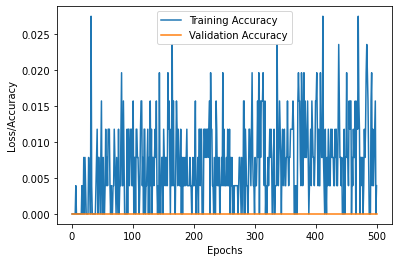

In [39]:
epochs = range(1, len(history10.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history10.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history10.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [40]:
x = [i for i in range(int(testing_features10[0,-1]+1), int(testing_features10[-1,-1]+2))]
y = testing_labels10
x_pred = testing_features10
y_pred = NN_model.predict(x_pred) 
err10 = np.abs(y - y_pred)
acc10 = np.ones(len(y)) - np.divide(err10, y)
acc_bar10 = np.mean(acc10)
rms10 = np.sqrt(np.mean((err10)**2))
print("Average accuracy:", acc_bar10)
print("RMS:", rms10)

Average accuracy: 0.7936173677015979
RMS: 864548.4312807493


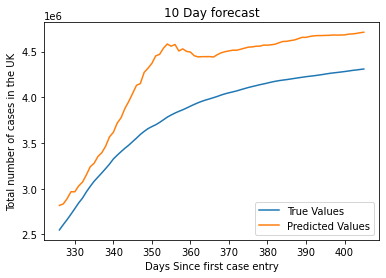

In [41]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("10 Day forecast")
plt.legend()
plt.show()

In [42]:
window_size = 7
forecast = 50
features50, labels50 = create_features(pos_cases_df, window_size, forecast)

In [43]:
training_features50, testing_features50 = np.split(features50, [int(0.8*len(features50))])
training_labels50, testing_labels50 = np.split(labels50, [int(0.8*len(labels50))])

In [44]:
history50 = NN_model.fit(training_features50, training_labels50, epochs=500, validation_split=0.2)

Train on 229 samples, validate on 58 samples
Epoch 1/500
229/229 [==============================] - 0s 100us/step - loss: 129417.9461 - accuracy: 0.0000e+00 - val_loss: 391234.9844 - val_accuracy: 0.0000e+00
Epoch 2/500
229/229 [==============================] - 0s 92us/step - loss: 125651.3585 - accuracy: 0.0000e+00 - val_loss: 255906.1517 - val_accuracy: 0.0000e+00
Epoch 3/500
229/229 [==============================] - 0s 105us/step - loss: 115743.3832 - accuracy: 0.0000e+00 - val_loss: 496494.0183 - val_accuracy: 0.0000e+00
Epoch 4/500
229/229 [==============================] - 0s 96us/step - loss: 104698.4610 - accuracy: 0.0000e+00 - val_loss: 612479.4052 - val_accuracy: 0.0000e+00
Epoch 5/500
229/229 [==============================] - 0s 109us/step - loss: 104479.6546 - accuracy: 0.0000e+00 - val_loss: 595621.9698 - val_accuracy: 0.0000e+00
Epoch 6/500
229/229 [==============================] - 0s 105us/step - loss: 104484.6423 - accuracy: 0.0000e+00 - val_loss: 521107.1875 - val_

Epoch 51/500
229/229 [==============================] - 0s 96us/step - loss: 30008.4149 - accuracy: 0.0000e+00 - val_loss: 375808.2812 - val_accuracy: 0.0000e+00
Epoch 52/500
229/229 [==============================] - 0s 96us/step - loss: 26679.7962 - accuracy: 0.0000e+00 - val_loss: 468128.9353 - val_accuracy: 0.0000e+00
Epoch 53/500
229/229 [==============================] - 0s 87us/step - loss: 26095.5832 - accuracy: 0.0000e+00 - val_loss: 374063.5172 - val_accuracy: 0.0000e+00
Epoch 54/500
229/229 [==============================] - 0s 92us/step - loss: 25876.1300 - accuracy: 0.0000e+00 - val_loss: 391203.5830 - val_accuracy: 0.0000e+00
Epoch 55/500
229/229 [==============================] - 0s 92us/step - loss: 26085.8729 - accuracy: 0.0000e+00 - val_loss: 419624.9946 - val_accuracy: 0.0000e+00
Epoch 56/500
229/229 [==============================] - 0s 92us/step - loss: 25452.4480 - accuracy: 0.0000e+00 - val_loss: 440293.2360 - val_accuracy: 0.0000e+00
Epoch 57/500
229/229 [======

229/229 [==============================] - 0s 92us/step - loss: 14154.1425 - accuracy: 0.0000e+00 - val_loss: 377055.5744 - val_accuracy: 0.0000e+00
Epoch 152/500
229/229 [==============================] - 0s 87us/step - loss: 15370.2773 - accuracy: 0.0000e+00 - val_loss: 417504.9892 - val_accuracy: 0.0000e+00
Epoch 153/500
229/229 [==============================] - 0s 92us/step - loss: 17927.5028 - accuracy: 0.0000e+00 - val_loss: 427567.5873 - val_accuracy: 0.0000e+00
Epoch 154/500
229/229 [==============================] - 0s 87us/step - loss: 18250.1532 - accuracy: 0.0000e+00 - val_loss: 460812.5216 - val_accuracy: 0.0000e+00
Epoch 155/500
229/229 [==============================] - 0s 96us/step - loss: 21136.7736 - accuracy: 0.0000e+00 - val_loss: 432600.6088 - val_accuracy: 0.0000e+00
Epoch 156/500
229/229 [==============================] - 0s 92us/step - loss: 17067.9421 - accuracy: 0.0000e+00 - val_loss: 357453.2177 - val_accuracy: 0.0000e+00
Epoch 157/500
229/229 [=============

229/229 [==============================] - 0s 96us/step - loss: 23411.6505 - accuracy: 0.0000e+00 - val_loss: 467372.0334 - val_accuracy: 0.0000e+00
Epoch 252/500
229/229 [==============================] - 0s 100us/step - loss: 16877.1418 - accuracy: 0.0000e+00 - val_loss: 479951.6638 - val_accuracy: 0.0000e+00
Epoch 253/500
229/229 [==============================] - 0s 92us/step - loss: 20373.0811 - accuracy: 0.0000e+00 - val_loss: 425135.0830 - val_accuracy: 0.0000e+00
Epoch 254/500
229/229 [==============================] - 0s 92us/step - loss: 14975.3902 - accuracy: 0.0000e+00 - val_loss: 453620.9300 - val_accuracy: 0.0000e+00
Epoch 255/500
229/229 [==============================] - 0s 92us/step - loss: 18482.8542 - accuracy: 0.0000e+00 - val_loss: 301494.0496 - val_accuracy: 0.0000e+00
Epoch 256/500
229/229 [==============================] - 0s 96us/step - loss: 11968.0974 - accuracy: 0.0000e+00 - val_loss: 286716.9106 - val_accuracy: 0.0000e+00
Epoch 257/500
229/229 [============

229/229 [==============================] - 0s 96us/step - loss: 7720.8181 - accuracy: 0.0000e+00 - val_loss: 387840.2349 - val_accuracy: 0.0000e+00
Epoch 352/500
229/229 [==============================] - 0s 96us/step - loss: 7073.9572 - accuracy: 0.0000e+00 - val_loss: 458435.2209 - val_accuracy: 0.0000e+00
Epoch 353/500
229/229 [==============================] - 0s 94us/step - loss: 9376.2946 - accuracy: 0.0000e+00 - val_loss: 482403.8685 - val_accuracy: 0.0000e+00
Epoch 354/500
229/229 [==============================] - 0s 92us/step - loss: 10804.4815 - accuracy: 0.0000e+00 - val_loss: 409214.0000 - val_accuracy: 0.0000e+00
Epoch 355/500
229/229 [==============================] - 0s 87us/step - loss: 7783.4573 - accuracy: 0.0000e+00 - val_loss: 332208.9547 - val_accuracy: 0.0000e+00
Epoch 356/500
229/229 [==============================] - 0s 92us/step - loss: 13302.1003 - accuracy: 0.0000e+00 - val_loss: 338769.5162 - val_accuracy: 0.0000e+00
Epoch 357/500
229/229 [=================

229/229 [==============================] - 0s 92us/step - loss: 8889.9580 - accuracy: 0.0000e+00 - val_loss: 407481.6940 - val_accuracy: 0.0000e+00
Epoch 452/500
229/229 [==============================] - 0s 96us/step - loss: 9241.3126 - accuracy: 0.0000e+00 - val_loss: 416930.4429 - val_accuracy: 0.0000e+00
Epoch 453/500
229/229 [==============================] - 0s 96us/step - loss: 8073.4622 - accuracy: 0.0000e+00 - val_loss: 432419.5409 - val_accuracy: 0.0000e+00
Epoch 454/500
229/229 [==============================] - 0s 92us/step - loss: 8136.9460 - accuracy: 0.0044 - val_loss: 439472.7759 - val_accuracy: 0.0000e+00
Epoch 455/500
229/229 [==============================] - 0s 92us/step - loss: 8275.8253 - accuracy: 0.0000e+00 - val_loss: 453478.6239 - val_accuracy: 0.0000e+00
Epoch 456/500
229/229 [==============================] - 0s 92us/step - loss: 8092.3500 - accuracy: 0.0000e+00 - val_loss: 447849.4795 - val_accuracy: 0.0000e+00
Epoch 457/500
229/229 [=======================

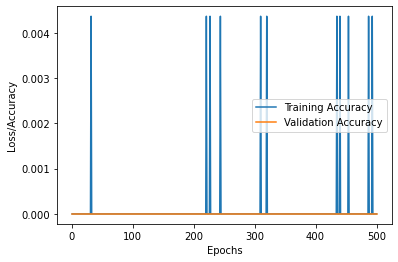

In [45]:
epochs = range(1, len(history50.epoch) + 1)
# plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history50.history['accuracy'], label='Training Accuracy')
# plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [46]:
x = [i for i in range(int(testing_features50[0,-1]+1), int(testing_features50[-1,-1]+2))]
y = testing_labels50
x_pred = testing_features50
y_pred = NN_model.predict(x_pred) 
err50 = np.abs(y - y_pred)
acc50 = np.ones(len(y)) - np.divide(err50, y)
acc_bar50 = np.mean(acc50)
rms50 = np.sqrt(np.mean((err50)**2))
print("Average accuracy:", acc_bar50)
print("RMS:", rms50)

Average accuracy: 0.628519108633852
RMS: 2216767.213346338


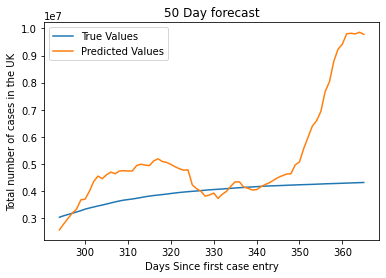

In [47]:
plt.plot(x, y, label="True Values")
plt.plot(x, y_pred, label="Predicted Values")
plt.xlabel("Days Since first case entry")
plt.ylabel("Total number of cases in the UK")
plt.title("50 Day forecast")
plt.legend()
plt.show()